# MLPS - Mercari Price ML

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Perform data cleaning

In [ ]:
data = pd.read_csv("Data/train.tsv", delimiter="\t", index_col=0)

# remove items with out a price
data = data[pd.notna(data["price"])]

data["item_description"] = data["item_description"].replace("No description yet", "")
data["item_description"] = data["item_description"].replace(np.nan, "")

temp = data["category_name"].fillna('').str.split('/')
              
data["category_name_1"] = temp.str[0]
data["category_name_2"] = temp.str[1]
data["category_name_3"] = temp.str[2:].str.join("/")

### Implement porter stemming in count vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.porter import *
import string

class StemmerTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()
        self.translator = str.maketrans('', '', string.punctuation + string.digits)
    def __call__(self, doc):
        return [self.ps.stem(w) for w in doc
                .encode('ascii', errors='ignore')
                .decode('ascii')
                .translate(self.translator)
                .split()]

vectorizer = CountVectorizer(lowercase = True,
                             max_df = .5,
                             min_df = .001,
                             tokenizer = StemmerTokenizer(),
                             stop_words='english')

### Count vectorize the data

In [ ]:
%%time
tfm = vectorizer.fit_transform(data["item_description"])

In [ ]:
vocab = vectorizer.vocabulary_ 
removed_words = vectorizer.stop_words_

In [ ]:
%%time
tfidf_vectorizer = TfidfTransformer()
tfidf_transformed = tfidf_vectorizer.fit_transform(tfm)

### Save results for time savings

In [ ]:
from scipy.sparse import save_npz
save_npz("tfm.npz", tfm)
save_npz("tfidf_transformed.npz", tfidf_transformed)

## Vocab: write vectorized words to txt

In [ ]:
import operator
with open("vocabulary.txt", "w") as f:
    f.write("".join([k + '\n' for k, v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]))

<br><br><br><hr><hr>

# Load files as necessary for time savings

In [1]:
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from scipy.sparse import load_npz

tfm = load_npz("Data/tfm.npz")
tfidf_transformed = load_npz("Data/tfidf_transformed.npz")
categorical = pd.read_csv('Data/train_clean.tsv', sep='\t', header=0)

In [2]:
# take the log of price (0.000000001 added for item with 0 as price)
categorical['log(price)'] = np.log(categorical['price'] + 0.000000001)

# calculate 6 st dev of log(price)
st_dev_log_price_6 = categorical['log(price)'].std()*6

print("pre-filtering ",len(categorical))

# find points that are not outliers
not_outliers = np.array((categorical['log(price)'] < st_dev_log_price_6) & (categorical['log(price)'] > (- st_dev_log_price_6)))

# filter datasets to data only around 6 st dev of log(price)
cleaned_categorical = categorical[not_outliers]
cleaned_categorical.reset_index(drop = True, inplace = True)
tfm = tfm[not_outliers]
tfidf_transformed = tfidf_transformed[not_outliers]

print("post-filtering ",len(cleaned_categorical))

pre-filtering  1482535
post-filtering  1478823


In [3]:
cleaned_categorical.describe()

,train_id,item_condition_id,price,shipping,log(price)
count,1478823.000,1478823.000,1478823.000,1478823.000,1478823.000
mean,741229.160,1.907,25.753,0.447,2.907
std,427967.781,0.903,29.028,0.497,0.776
min,0.000,1.000,3.000,0.000,1.099
25%,370559.500,1.000,10.000,0.000,2.303
50%,741224.000,2.000,17.000,0.000,2.833
75%,1111850.500,3.000,29.000,1.000,3.367
max,1482534.000,5.000,347.000,1.000,5.849


In [4]:

cleaned_categorical["brand_name"][cleaned_categorical["brand_name"].isnull()] = "No Brand Info"

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


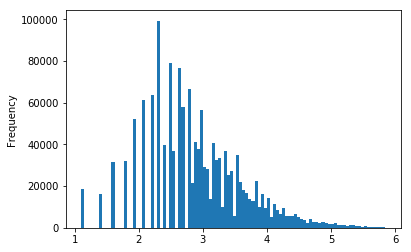

In [5]:
%matplotlib inline
cleaned_categorical['log(price)'].plot.hist(bins= 100)


In [6]:
tfm.shape

(1478823, 1793)

In [7]:
tfidf_transformed.shape

(1478823, 1793)

In [8]:
cleaned_categorical.shape

(1478823, 12)

## Split into train and test

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_categorical = cleaned_categorical['price']
cleaned_categorical.drop(["train_id","name","category_name","item_description","price", 'log(price)'], axis=1, inplace=True)
cleaned_categorical["item_condition_id"] = cleaned_categorical["item_condition_id"].astype('str', copy=False)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
y_categorical.isna().sum()

0

In [11]:
ohe_cleaned_categorical = pd.get_dummies(cleaned_categorical)

In [12]:
#Test Train sample size
import numpy as np
n_sample = 100000
sample = np.random.permutation(y_categorical.shape[0])[:n_sample]

In [13]:
y_categorical_sample = y_categorical[sample]
ohe_cleaned_categorical_sample = ohe_cleaned_categorical.iloc[sample]
tfidf_transformed_sample = tfidf_transformed[sample]

ohe_cleaned_categorical_sample.reset_index(drop = True, inplace = True);
y_categorical_sample.reset_index(drop = True, inplace = True);

y_categorical.isna().sum()

In [14]:
# split into train and test
yTrain, yTest, XTrain, XTest, tfidfTrain, tfidfTest = train_test_split(
    y_categorical_sample, ohe_cleaned_categorical_sample, tfidf_transformed_sample, test_size=0.3, random_state=95)

yTrain.reset_index(drop = True, inplace = True)
yTest.reset_index(drop = True, inplace = True)
XTrain.reset_index(drop = True, inplace = True)
XTest.reset_index(drop = True, inplace = True);


In [15]:
yTrain.isna().sum()

0

In [16]:
# specify number of folds
from sklearn.model_selection import KFold
folds = 2
kf = KFold(n_splits=folds)

In [19]:
%time
# Test train and validate
alpha_values = [0.001, 0.01, 0.1, 1]
alpha_inner_values = [0.001, 0.01]
from sklearn.linear_model import Lasso
import copy

mseOuterTrain = []
mseOuterVal = []
mseInnerTrain = []
mseInnerVal = []
mseOverallTrain = []
mseOverallVal= []

for i, (train_index, val_index) in enumerate(kf.split(yTrain)):
    print(i)
    yTrain_fold = yTrain.iloc[train_index]
    yVal_fold = yTrain.iloc[val_index]

    XTrain_fold = XTrain.iloc[train_index]
    XVal_fold = XTrain.iloc[val_index]
    
    tfidfTrain_fold = tfidfTrain[train_index]
    tfidfVal_fold = tfidfTrain[val_index]
    

    for a_outer in alpha_values:
        print(i, a_outer)
        lasso = Lasso(alpha=a_outer, random_state=111, max_iter=1000).fit(XTrain_fold, yTrain_fold)
        predict_train = lasso.predict(XTrain_fold)
        train_residuals = yTrain_fold - predict_train
        mseOuterTrain.append(copy.deepcopy((i, a_outer ,None, np.square(train_residuals).mean())))
        
        predict_val = lasso.predict(XVal_fold)
        val_residuals = yVal_fold - predict_val
        mseOuterVal.append(copy.deepcopy((i, a_outer , None, np.square(val_residuals).mean())))
        
        for a_inner in alpha_inner_values:
            print(i, a_outer, a_inner)
            lasso_inner = Lasso(alpha=a_inner, random_state=111, max_iter=1000).fit(tfidfTrain_fold, train_residuals)
            predict_inner_train = lasso_inner.predict(tfidfTrain_fold)
            inner_train_residuals = train_residuals - predict_inner_train
            mseInnerTrain.append(copy.deepcopy((i, a_inner, np.square(inner_train_residuals).mean())))

            predict_inner_val = lasso_inner.predict(tfidfVal_fold)
            inner_val_residuals = val_residuals - predict_inner_val
            mseInnerVal.append(copy.deepcopy((i, a_inner, np.square(inner_val_residuals).mean())))

            residuals_overall_train = yTrain_fold - predict_train - predict_inner_train
            mseOverallTrain.append(copy.deepcopy((i, a_outer, a_inner, np.square(residuals_overall_train).mean())))

            residuals_overall_val = yVal_fold - predict_val - predict_inner_val
            mseOverallVal.append(copy.deepcopy((i, a_outer, a_inner, np.square(residuals_overall_val).mean())))
    

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
0
0 0.001
0 0.001 0.001
0 0.001 0.01
0 0.01
0 0.01 0.001
0 0.01 0.01
0 0.1
0 0.1 0.001
0 0.1 0.01
0 1
0 1 0.001
0 1 0.01
1
1 0.001
1 0.001 0.001
1 0.001 0.01
1 0.01
1 0.01 0.001
1 0.01 0.01
1 0.1
1 0.1 0.001
1 0.1 0.01
1 1
1 1 0.001
1 1 0.01


In [21]:
import operator
sorted(mseOverallVal, key = operator.itemgetter(3))

[(1, 0.001, 0.001, 537.8424368915587),
 (1, 0.01, 0.001, 541.7957137672096),
 (1, 0.001, 0.01, 548.5032824515748),
 (1, 0.01, 0.01, 555.2455748046898),
 (1, 0.1, 0.001, 593.1901232125064),
 (0, 0.001, 0.001, 593.6364120389524),
 (0, 0.01, 0.001, 598.3875588873835),
 (0, 0.001, 0.01, 603.9947970657068),
 (0, 0.01, 0.01, 611.1155584590944),
 (1, 0.1, 0.01, 617.188612694948),
 (1, 1, 0.001, 631.4570159583806),
 (0, 0.1, 0.001, 647.547198049096),
 (1, 1, 0.01, 658.8781379084553),
 (0, 0.1, 0.01, 671.8913832212985),
 (0, 1, 0.001, 691.6456001061263),
 (0, 1, 0.01, 723.3536005844179)]

AttributeError: 'list' object has no attribute 'groupby'

In [24]:
import operator
sorted(mseOuterVal, key = operator.itemgetter(3))

[(1, 0.001, None, 569.5284216644386),
 (1, 0.01, None, 584.1053047616421),
 (0, 0.001, None, 624.6809628402181),
 (0, 0.01, None, 640.466910979057),
 (1, 0.1, None, 683.212800645272),
 (0, 0.1, None, 737.6382676182643),
 (1, 1, None, 779.749562256277),
 (0, 1, None, 840.4386399922018)]

In [27]:
pd.DataFrame(mseOverallVal).groupby([1,2]).mean()

0       3
1     2                  
0.001 0.001 0.500 565.739
      0.010 0.500 576.249
0.010 0.001 0.500 570.092
      0.010 0.500 583.181
0.100 0.001 0.500 620.369
      0.010 0.500 644.540
1.000 0.001 0.500 661.551
      0.010 0.500 691.116

In [28]:
pd.DataFrame(mseOuterVal).groupby([1]).mean()

,0,3
1,,
0.001,0.500,597.105
0.010,0.500,612.286
0.100,0.500,710.426
1.000,0.500,810.094


In [29]:
from sklearn.linear_model import Lasso
import copy
lasso = Lasso(alpha=0.001, random_state=111, max_iter=1000).fit(XTrain, yTrain)
pred = lasso.predict(XTrain)
lasso.score(XTrain, yTrain)

0.33348268747080134

In [ ]:
# from sklearn.linear_model import Lasso
# import copy
# lasso = Lasso(alpha=0.1, random_state=111, max_iter=1000).fit(XTrain, yTrain)
# pred = lasso.predict(XTrain)
# lasso.score(XTrain, yTrain)

In [30]:
lasso_res = Lasso(alpha=0.001, random_state=111, max_iter=1000).fit(tfidfTrain, (pred - yTrain))
pred_res = lasso_res.predict(tfidfTrain)
lasso_res.score(tfidfTrain, (pred - yTrain))

0.0974643236016256

In [31]:
#pred_res = lasso_res.predict(tfidfTrain)

In [32]:
#pred_plus = pred + pred_res

692.055945829208


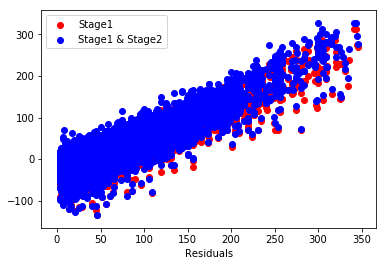

In [52]:
pred = lasso.predict(XTrain)

pred_res = lasso_res.predict(tfidfTrain)
print(np.square(yTrain - pred - pred_res).mean())

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.scatter(yTrain, yTrain-pred, c= "r", label = "Stage1")
plt.scatter(yTrain, yTrain-pred - pred_res, c = "b", label = "Stage1 & Stage2")
plt.legend()
plt.xlabel("Price")
plt.xlabel("Residuals")
plt.savefig("moneygraph.png")

In [ ]:
np.square(yTrain-pred).mean()

In [ ]:
np.square(yTrain-pred_plus).mean()

In [ ]:
lasso.coef_

In [37]:
pd.DataFrame()

,0
0,-0.000
1,0.000
2,-8.118
3,-10.192
4,0.000
5,4.240
6,0.000
7,-0.000
8,-5.199
9,0.000


In [39]:
from scipy.sparse import load_npz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

vocab = np.genfromtxt("Data/vocabulary.txt",dtype="str")

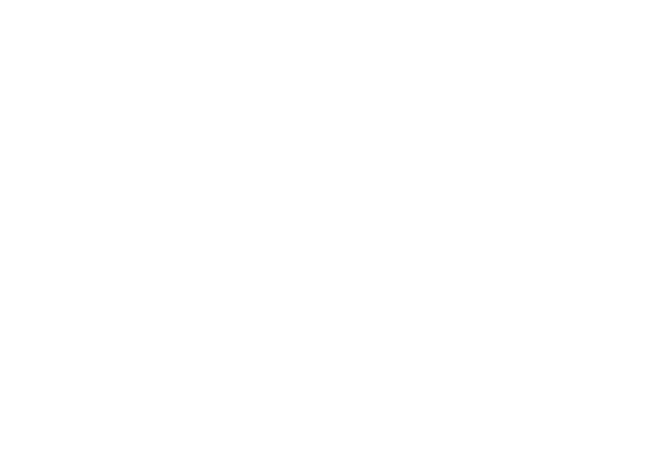

In [43]:
def makeWC(vocab, data, save_name, height, width):
    dictionary = dict(zip(vocab, data))
    wc = WordCloud(background_color="white", width=1100, height= 800)
    wc.generate_from_frequencies(frequencies = dictionary)
    plt.figure(figsize=(height,width))
    plt.axis("off")
    plt.imsave(save_name, wc, dpi=600)

wc = makeWC(vocab[np.where(lasso_res.coef_ > 0)], lasso_res.coef_[np.where(lasso_res.coef_ > 0)], "WC_lasso_coef_final_model.png", 11,8)

In [42]:
np.where(lasso_res.coef_ > 0)

(array([   5,   13,   16,   21,   22,   23,   40,   44,   45,   57,   58,
          59,   60,   63,   75,   78,   80,   89,   96,   99,  101,  102,
         106,  117,  121,  122,  134,  136,  143,  147,  164,  166,  168,
         172,  176,  182,  186,  188,  189,  193,  198,  203,  209,  210,
         211,  214,  222,  230,  239,  245,  249,  251,  255,  257,  258,
         259,  268,  271,  275,  277,  284,  285,  288,  290,  295,  306,
         307,  310,  311,  313,  327,  332,  333,  335,  349,  354,  365,
         368,  370,  375,  383,  398,  407,  415,  417,  420,  421,  423,
         427,  432,  433,  436,  440,  442,  443,  452,  456,  471,  473,
         474,  475,  481,  482,  492,  495,  507,  517,  519,  523,  528,
         529,  540,  542,  555,  557,  562,  564,  565,  570,  572,  577,
         579,  583,  585,  597,  600,  601,  607,  615,  616,  618,  626,
         628,  629,  630,  638,  642,  648,  649,  650,  652,  667,  669,
         671,  680,  681,  692,  698, 

## Lasso: Category (non-text) data

In [ ]:
vocab = pd.read_csv('Data/vocabulary.txt', sep=" ", header=None)

In [ ]:
%%time
from sklearn.linear_model import LassoCV, Lasso

#alpha_values = np.logspace(-4, 2, 6)
alpha_values = [0.001,0.01,0.1]

mseRow = []
mseAll = []
mseOuterTrain = []
mseOuterValidate = []
mseInner = []

#manually grid search over alpha
for alphaOut in alpha_values:
    
    #non-Text data
    lasso = Lasso(alpha=alphaOut, random_state=111, max_iter=1000).fit(XTrain, yTrain)
    yPredOut = lasso.predict(XValid)
    residuals = yValid - yPredOut
    
    mseRow = []
    
    #can't figure out how to implement a validation or test accuracy as the training of the inner model is dependent 
    # on the outermodel's predictions.  If we predict on XValid, then we need to train the inner model on XValid.
    # not sure if this makes sense
    
    #GridSearch manually
    for alphaIn in alpha_values:
        lassoTF = Lasso(alpha=alphaIn, random_state=777, max_iter=1000).fit(tfidfValid, residuals)
        yPredIn = lassoTF.predict(tfidfValid)
        
        #add predictions from non-Text and Text regressions
        yPredFull = yPredOut + yPredIn
        
        #calc mse between full predictions & actuals
        mseRow.append(mean_squared_error(yValid, yPredFull))
    
    #store for of mse's
    mseAll.append(mseRow)
    
mseAll = np.array(mseAll)

In [ ]:
#get bestAlphaOut & In based on the smallest mse from gridsearch
bestAlpha_idx = np.unravel_index(np.argmin(mseAll), mseAll.shape)
#bestAlpha_idx[0]
bestAlphaOut = alpha_values[bestAlpha_idx[0]]
bestAlphaIn = alpha_values[bestAlpha_idx[1]]
print()
print("Best Alpha for Outer Lasso (non-text): {}".format(bestAlphaOut))
print("Best Alpha for Linner Lasso (text): {}".format(bestAlphaIn))

## Run final model with bestAlphas

In [ ]:
lasso = Lasso(alpha=bestAlphaOut, random_state=111).fit(XTrain, yTrain)
yPredOut = lasso.predict(XValid)
residualsBest = yValid - yPredOut

lassoTF = Lasso(alpha=bestAlphaIn, random_state=111).fit(tfidfTrain, residualsBest)
yPredIn = lasso.predict(tfidfValid)

yPredFull = yPredOut + yPredIn

mse_Final = mean_squared_error(yValid, yPredFull)
print("The MSE for the final tuned models is: {}".format(mse_Final))

## Pickle trained models

In [ ]:
from sklearn.externals import joblib
joblib.dump(lasso, 'lasso_cat.pkl')
joblib.dump(lassTF, 'lasso_tfidf.pkl')
#clf = joblib.load('lasso_cat.pkl') 

# Combine non-Text & text data and run Lasso to see if prediction is diff

In [ ]:
#combine non-Text and Text to test it out
# tfDTrain = tfidfTrain.todense()
# comboTrain = pd.concat([XTrain.reset_index(drop = True), pd.DataFrame(tfDTrain)], axis=1)
# comboTrain.shape

In [ ]:
#save lasso on category data as DataFrame, write to csv
# lasso_cat_coef = pd.DataFrame(lasso.coef_, index=XTrain.columns)
# lasso_cat_coef.to_csv("lasso_cat_coef.csv")

# residualsDF = pd.DataFrame(residuals)
# residualsDF.to_csv("residuals.csv")

## Lasso: Text data on residuals

In [ ]:
#save lasso on TFIDF data as DataFrame, write to csv
# lasso_tfidf_coef = pd.DataFrame(lassoTF.coef_, index=vocab.iloc[:,0].values)
# lasso_tfidf_coef.to_csv("lasso_tfidf_coef.csv")

## Lasso: Text data on residuals (per category1)

In [ ]:
#get the category1 column headers
cat1_cols = XTrain.iloc[:,4815:4825].columns

#reset index so can filter using list of indices
residuals.reset_index(drop=True, inplace=True)

In [ ]:
%%time
cat1_coefs = []
tfidfTrain_df = pd.DataFrame(tfidfTrain.todense())  #I think can remove this and uncomment tocsr() line below

for cat1 in cat1_cols:
    #get indices where this category=1
    idx = np.where(XTrain[cat1] == 1)[0]
   
    #filter data with the indices
    X_tf = tfidfTrain_df.iloc[idx,:]   #Don't think need to use this, uncomment next time to deal with sparse
    #X_tf = tfidfTrain.tocsr()[idx,:]  #way to filter sparse matrx with row indices
    y_tf = residuals[idx]
    
    #run Lasso, fit, store coef array
    lassoCat = Lasso(alpha=bestAlphaIn, random_state=10)
    lassoCat.fit(X_tf, y_tf)

    #add this cat1 coefs to a list
    cat1_coefs.append(lassoCat.coef_)

In [ ]:
#covert to DF with cols=vocab and index=category1 names
lasso_allCat1_coef = pd.DataFrame(cat1_coefs, columns=vocab.iloc[:,0].values, index=cat1_cols)
lasso_allCat1_coef.to_csv("lass_allCat1_coef.csv")

<hr><hr><br>

## Recurrent Neural Network

In [ ]:
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation, Reshape
# from keras.layers.recurrent import LSTM, RNN, GRU, SimpleRNN
# from keras.models import load_model
# import keras
# import h5py



In [ ]:
# #default layers = 6, neurons list always should equal 6
# def build_NN(inShape, nnType='RNN'):
    
#     model = Sequential()
#     model.add(Embedding(inShape[1], 64, input_length=maxLen))  #input layer
#     if nnType == 'RNN':
#         model.add(SimpleRNN(32, return_sequences=True))
#         model.add(SimpleRNN(32))
#         model.add(Dense(16, activation='relu'))
#         model.add(Dense(8, activation='relu'))
#     elif nnType == 'GRU':
#         #model.add(Dense(64, input_shape=(inShape[1])))  #input layer
#         model.add(GRU(32, return_sequences=True))
#         model.add(GRU(32))
#         model.add(Dense(16, activation='relu'))
#         model.add(Dense(8, activation='relu'))
#     elif nnType == 'LSTM':
#         #model.add(Dense(64, input_shape=(inShape[1])))  #input layer
#         model.add(LSTM(32, return_sequences=True)) 
#         model.add(LSTM(32))
#         model.add(Dense(16, activation='relu'))      
#         model.add(Dense(8, activation='relu'))
#     elif nnType == 'BASE':
#         #model.add(Dense(64, input_shape=(inShape[1],)))  #input layer
#         model.add(Dense(32, activation='relu'))
#         model.add(Dense(32, activation='relu'))
#         model.add(Dense(16, activation='relu'))
#         model.add(Reshape((-1,)))
#         model.add(Dense(8, activation='relu'))
#     else:
#         print('should not be here')
    
#     model.add(Dense(1, activation='linear', kernel_initializer="uniform")) #output layer
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#     #model.summary() 

#     return model

In [ ]:
# #params for NN
# epochs = 10
# batchSize = 3000

# #Need to prep the data for the NN

# X = tokenizer.texts_to_sequences(train5k)
# data = pad_sequences(sequences, maxlen=max_len)


# modelRNN = build_NN(tfidf_train.shape, nnType='RNN')
# modelRNN.summary()